In [203]:
import requests
import numpy as np
import pandas as pd
import io
import geopandas as gpd
from shapely.geometry import shape, Point
from shapely.ops import unary_union
import matplotlib.pyplot as plt

In [16]:
os = 0
params = {'$limit': 1000, '$offset': os}
response = requests.get('https://data.cityofchicago.org/resource/xqx5-8hwx.json', params).json()
total_response = response
os = 1000
while len(response) >= 1000:
    params = {'$limit': 1000, '$offset': os}
    response = requests.get('https://data.cityofchicago.org/resource/xqx5-8hwx.json', params).json()
    os += 1000
    total_response += response

In [17]:
business_df = pd.DataFrame.from_dict(total_response)
business_df.columns

Index([':@computed_region_43wa_7qmu', ':@computed_region_6mkv_f3dw',
       ':@computed_region_awaf_s7ux', ':@computed_region_bdys_3d7i',
       ':@computed_region_vrxf_vc4k', 'account_number', 'address',
       'application_created_date', 'application_requirements_complete',
       'application_type', 'business_activity', 'business_activity_id', 'city',
       'conditional_approval', 'date_issued', 'doing_business_as_name',
       'expiration_date', 'id', 'latitude', 'legal_name',
       'license_approved_for_issuance', 'license_code', 'license_description',
       'license_id', 'license_number', 'license_start_date', 'license_status',
       'license_status_change_date', 'location', 'longitude', 'payment_date',
       'police_district', 'precinct', 'site_number', 'ssa', 'state', 'ward',
       'ward_precinct', 'zip_code'],
      dtype='object')

In [18]:
business_df.shape

(968908, 39)

In [19]:
for col in business_df.columns: 
    if "date" in col:
        business_df[col] = pd.to_datetime(business_df[col])

In [20]:
to_drop_lst = []
for col in business_df.columns:
  if "computed" in col:
    to_drop_lst.append(col)
business_df.drop(to_drop_lst, axis=1, inplace=True )

In [21]:
ACS_RACE = {
    "B03002_001E": "race_respondents", # total population
    "B03002_003E": "race_white", # non-Hispanic white
    "B03002_004E": "race_black", # non-Hispanic black
    "B03002_006E": "race_asian", # non-Hispanic Asian
    "B03002_012E": "race_hispanic"}

In [22]:
ACS_HOUSEHOLD_INCOME = {
    "B19001_001E": "hhinc_respondents",
    "B19001_002E": "hhinc_00_10K",
    "B19001_003E": "hhinc_10_15K",
    "B19001_004E": "hhinc_15_20K",
    "B19001_005E": "hhinc_20_25K",
    "B19001_006E": "hhinc_25_30K",
    "B19001_007E": "hhinc_30_35K",
    "B19001_008E": "hhinc_35_40K",
    "B19001_009E": "hhinc_40_45K",
    "B19001_010E": "hhinc_45_50K",
    "B19001_011E": "hhinc_50_60K",
    "B19001_012E": "hhinc_60_75K",
    "B19001_013E": "hhinc_75_100K",
    "B19001_014E": "hhinc_100_125K",
    "B19001_015E": "hhinc_125_150K",
    "B19001_016E": "hhinc_150_200K"}

In [23]:
ACS_VARIABLES = [ACS_RACE, ACS_HOUSEHOLD_INCOME]
ACS_API = "https://api.census.gov/data/2017/acs/acs5"

In [24]:
def set_census_data_params(variable_dict):
    parameters = {
        "get": ",".join(var for var in variable_dict.keys()),
        "for": "block group:*",
        "in": "state:17 county:031"} # Cook County, Illinois
    return parameters

In [25]:
def request_census_data(variable_dict):
    request = requests.get(
        ACS_API,
        params=set_census_data_params(variable_dict))
    census_data = request.json()
    labels = [variable_dict.get(var, var) for var in census_data.pop(0)]
    census_data = pd.DataFrame(census_data, columns=labels)
    return census_data

In [26]:
def compile_census_data(variable_dicts):
    LOCATION_VARIABLES = ["state", "county", "tract", "block group"]
    census_data = request_census_data(variable_dicts.pop())
    for variable_dict in variable_dicts:
        census_data = census_data \
            .merge(
                request_census_data(variable_dict),
                how="outer",
                on=LOCATION_VARIABLES)
    census_data["block_group"] = census_data \
        .apply(
            lambda row: "".join(str(row[var]) for var in LOCATION_VARIABLES),
            axis=1)
    census_data = census_data \
        .drop(columns=LOCATION_VARIABLES)
    return census_data

In [27]:
census_data = compile_census_data(ACS_VARIABLES)

In [28]:
os = 0
params = {'$limit': 1000, '$offset': os}
response = requests.get('https://data.cityofchicago.org/resource/bt9m-d2mf.json', params).json()
total_response = response
os = 1000
while len(response) >= 1000:
    params = {'$limit': 1000, '$offset': os}
    response = requests.get("https://data.cityofchicago.org/resource/bt9m-d2mf.json", params).json()
    os += 1000
    total_response += response
blocks = pd.DataFrame.from_dict(total_response)

In [ ]:
blocks["block_group"] = blocks["geoid10"].apply(lambda block: block[:12])

In [179]:
blocks["the_geom"] = blocks["the_geom"].apply(shape).apply(unary_union)
blocks = gpd.GeoDataFrame(blocks).set_geometry("the_geom").drop(columns=blocks.columns.difference(["block_group", "the_geom"]))
tracts_gdf = gpd.GeoDataFrame(blocks).set_geometry('the_geom')
tracts_gdf

,the_geom,block_group
0,POLYGON ((-87.62906799941059 41.76908600007152...,170316903002
1,"POLYGON ((-87.6341179992764 41.77446599958471,...",170316809003
2,POLYGON ((-87.63485400018324 41.77263300022619...,170316809003
3,POLYGON ((-87.73841099998789 41.85913100037079...,170312909004
4,POLYGON ((-87.73217300001724 41.85476400046529...,170312925004
5,POLYGON ((-87.72984100036327 41.85880000073347...,170312925004
6,POLYGON ((-87.70401800042956 41.85132199984943...,170313009002
7,POLYGON ((-87.69811999961215 41.85095099943977...,170318407002
8,POLYGON ((-87.69057000011132 41.85287899955381...,170318407003
9,POLYGON ((-87.67407699954941 41.69674300021378...,170317502003


In [171]:
def join_with_block_groups(business_df, blocks):
    business_df = business_df.dropna(subset=["longitude", "latitude"])
    business_df["the_geom"] = business_df.apply(lambda row: Point(float(row["longitude"]), float(row["latitude"])), axis=1)
    business_gdf = gpd.GeoDataFrame(business_df).set_geometry("the_geom")
    joined_data = gpd.sjoin(business_gdf, blocks[["block_group", "the_geom"]]).drop(columns="index_right")
    return joined_data

In [172]:
joined = join_with_block_groups(business_df, tracts_gdf)

/Users/katykoeing/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [173]:
augmented_df = pd.merge(joined, census_data, on="block_group")

In [174]:
augmented_df.iloc[1]

account_number                                                                  292686
address                                                        5300 S PULASKI RD 1ST C
application_created_date                                                           NaT
application_requirements_complete                              2015-11-15T00:00:00.000
application_type                                                                 RENEW
business_activity                    Tattoo / Permanent Body Art and Make-Up / Micr...
business_activity_id                                                               828
city                                                                           CHICAGO
conditional_approval                                                                 N
date_issued                                                        2016-01-13 00:00:00
doing_business_as_name                                               SICK LIFE TATTOOS
expiration_date                            

In [34]:
augmented_df.head()

,account_number,address,application_created_date,application_requirements_complete,application_type,business_activity,business_activity_id,city,conditional_approval,date_issued,...,hhinc_60_75K,hhinc_75_100K,hhinc_100_125K,hhinc_125_150K,hhinc_150_200K,race_respondents,race_white,race_black,race_asian,race_hispanic
0,419887,5300 S PULASKI RD 1ST,2017-08-02,2017-08-04T00:00:00.000,ISSUE,Automatic Food Vending Machine Business | Misc...,963 | 708,CHICAGO,N,2017-08-04,...,23,47,16,33,8,776,259,0,105,412
1,292686,5300 S PULASKI RD 1ST C,NaT,2015-11-15T00:00:00.000,RENEW,Tattoo / Permanent Body Art and Make-Up / Micr...,828,CHICAGO,N,2016-01-13,...,23,47,16,33,8,776,259,0,105,412
2,292686,5300 S PULASKI RD 1ST C,2014-02-13,2014-02-13T00:00:00.000,ISSUE,Tattoo / Permanent Body Art and Make-Up / Micr...,828,CHICAGO,N,2014-02-13,...,23,47,16,33,8,776,259,0,105,412
3,85325,5324 S PULASKI RD,NaT,2019-01-15T00:00:00.000,RENEW,Retail Sale of Tobacco,763,CHICAGO,N,2019-03-08,...,23,47,16,33,8,776,259,0,105,412
4,402097,5302 S PULASKI RD 1ST FRONT,NaT,2017-11-15T00:00:00.000,RENEW,Sale of Food Prepared Onsite With Dining Area,781,CHICAGO,N,2018-01-16,...,23,47,16,33,8,776,259,0,105,412


os = 0
params = {'$limit': 1000, '$offset': os, 'duplicate': False}
response = requests.get("https://data.cityofchicago.org/resource/v6vf-nfxy.json?$where=latitude IS NOT NULL and created_date>='2002-01-01T00:00:00.000'", params).json()
total_response = response
os = 1000
while len(response) >= 1000:
    params = {'$limit': 1000, '$offset': os, 'duplicate': False}
    response = requests.get("https://data.cityofchicago.org/resource/v6vf-nfxy.json?$where=latitude IS NOT NULL and created_date>='2002-01-01T00:00:00.000", params).json()
    os += 1000
    total_response += response

calls_df = pd.DataFrame.from_dict(total_response)

In [35]:
calls_df = pd.read_csv('311_Service_Requests.csv')

/Users/katykoeing/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (9,10,11,12,18,19,28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
calls_df.head()

,SR_NUMBER,SR_TYPE,SR_SHORT_CODE,OWNER_DEPARTMENT,STATUS,CREATED_DATE,LAST_MODIFIED_DATE,CLOSED_DATE,STREET_ADDRESS,CITY,...,PRECINCT,SANITATION_DIVISION_DAYS,CREATED_HOUR,CREATED_DAY_OF_WEEK,CREATED_MONTH,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE,LOCATION
0,SR19-01400559,Snow - Object/Dibs Removal Request,SDW,Streets and Sanitation,Open,04/28/2019 05:18:51 PM,04/28/2019 05:18:52 PM,NaN,1531 E 86TH ST,NaN,...,52.0,NaN,17,1,4,1.188047e+06,1.848189e+06,41.738519,-87.586620,"(41.73851911148112, -87.5866196367312)"
1,SR19-01400558,Stray Animal Complaint,EAE,Animal Care and Control,Open,04/28/2019 05:18:26 PM,04/28/2019 05:18:27 PM,NaN,7616 S SOUTH SHORE DR,NaN,...,14.0,NaN,17,1,4,1.196468e+06,1.855421e+06,41.758160,-87.555529,"(41.75815997700641, -87.55552933389464)"
2,SR19-01400546,Garbage Cart Maintenance,SIE,Streets and Sanitation,Open,04/28/2019 05:12:52 PM,04/28/2019 05:12:53 PM,NaN,1454 N HAMLIN AVE,NaN,...,16.0,NaN,17,1,4,1.150682e+06,1.909634e+06,41.907941,-87.721916,"(41.907940669087935, -87.7219164762201)"
3,SR19-01400545,Report an Injured Animal,EAQ,Animal Care and Control,Open,04/28/2019 05:12:29 PM,04/28/2019 05:12:30 PM,NaN,1054 N PAULINA ST,NaN,...,10.0,NaN,17,1,4,1.164786e+06,1.907297e+06,41.901240,-87.670171,"(41.90123961668129, -87.67017145161931)"
4,SR19-01400544,Garbage Cart Maintenance,SIE,Streets and Sanitation,Open,04/28/2019 05:12:19 PM,04/28/2019 05:12:19 PM,NaN,2330 W ARMITAGE AVE,NaN,...,32.0,NaN,17,1,4,NaN,NaN,41.917941,-87.686255,"(41.917940829250554, -87.6862550523112)"


In [40]:
def join_with_block_groups(business_df, blocks):
    business_df = business_df.dropna(subset=["LONGITUDE", "LATITUDE"])
    business_df["the_geom"] = business_df.apply(lambda row: Point(float(row["LONGITUDE"]), float(row["LATITUDE"])), axis=1)
    business_gdf = gpd.GeoDataFrame(business_df).set_geometry("the_geom")
    joined_data = gpd.sjoin(business_gdf, blocks[["block_group", "the_geom"]]).drop(columns="index_right")
    return joined_data

In [41]:
calls_w_tracts = join_with_block_groups(calls_df, tracts_gdf)

In [42]:
calls_w_tracts.head()

,SR_NUMBER,SR_TYPE,SR_SHORT_CODE,OWNER_DEPARTMENT,STATUS,CREATED_DATE,LAST_MODIFIED_DATE,CLOSED_DATE,STREET_ADDRESS,CITY,...,CREATED_HOUR,CREATED_DAY_OF_WEEK,CREATED_MONTH,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE,LOCATION,the_geom,block_group
0,SR19-01400559,Snow - Object/Dibs Removal Request,SDW,Streets and Sanitation,Open,04/28/2019 05:18:51 PM,04/28/2019 05:18:52 PM,NaN,1531 E 86TH ST,NaN,...,17,1,4,1.188047e+06,1.848189e+06,41.738519,-87.586620,"(41.73851911148112, -87.5866196367312)",POINT (-87.58661963700001 41.738519111),170318343004
1886,SR19-01398041,Sanitation Code Violation,SCB,Streets and Sanitation,Open,04/27/2019 08:06:54 PM,04/27/2019 08:06:56 PM,NaN,1531 E 86TH ST,NaN,...,20,7,4,1.188047e+06,1.848189e+06,41.738519,-87.586620,"(41.73851911148112, -87.5866196367312)",POINT (-87.58661963700001 41.738519111),170318343004
13517,SR19-01379157,Snow - Object/Dibs Removal Request,SDW,Streets and Sanitation,Completed,04/24/2019 11:58:26 AM,04/26/2019 09:45:45 AM,04/26/2019 09:45:45 AM,1531 E 86TH ST,NaN,...,11,4,4,1.188047e+06,1.848189e+06,41.738519,-87.586620,"(41.73851911148112, -87.5866196367312)",POINT (-87.58661963700001 41.738519111),170318343004
17281,SR19-01373107,Sanitation Code Violation,SCB,Streets and Sanitation,Open,04/23/2019 12:35:30 PM,04/27/2019 08:05:55 PM,NaN,1529 E 86TH ST,NaN,...,12,3,4,1.188017e+06,1.848189e+06,41.738522,-87.586732,"(41.73852161845877, -87.58673217893221)",POINT (-87.58673217899999 41.738521618),170318343004
43887,SR19-01331943,Street Light Out Complaint,SFD,CDOT - Department of Transportation,Open,04/15/2019 01:04:53 PM,04/16/2019 11:01:12 AM,NaN,1531 E 86TH ST,NaN,...,13,2,4,1.188047e+06,1.848189e+06,41.738519,-87.586620,"(41.73851911148112, -87.5866196367312)",POINT (-87.58661963700001 41.738519111),170318343004


In [43]:
calls_w_tracts.columns

Index(['SR_NUMBER', 'SR_TYPE', 'SR_SHORT_CODE', 'OWNER_DEPARTMENT', 'STATUS',
       'CREATED_DATE', 'LAST_MODIFIED_DATE', 'CLOSED_DATE', 'STREET_ADDRESS',
       'CITY', 'STATE', 'ZIP_CODE', 'STREET_NUMBER', 'STREET_DIRECTION',
       'STREET_NAME', 'STREET_TYPE', 'DUPLICATE', 'LEGACY_RECORD',
       'LEGACY_SR_NUMBER', 'PARENT_SR_NUMBER', 'COMMUNITY_AREA', 'WARD',
       'ELECTRICAL_DISTRICT', 'ELECTRICITY_GRID', 'POLICE_SECTOR',
       'POLICE_DISTRICT', 'POLICE_BEAT', 'PRECINCT',
       'SANITATION_DIVISION_DAYS', 'CREATED_HOUR', 'CREATED_DAY_OF_WEEK',
       'CREATED_MONTH', 'X_COORDINATE', 'Y_COORDINATE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'the_geom', 'block_group'],
      dtype='object')

In [49]:
blocks_by_calls = calls_w_tracts.groupby('block_group')['SR_NUMBER'].count().reset_index().sort_values('SR_NUMBER', ascending=False)

In [50]:
calls_w_tracts.groupby('block_group')['SR_TYPE'].value_counts().unstack().idxmax(axis=1)

block_group
170310101001              Abandoned Vehicle Complaint
170310101002             Rodent Baiting/Rat Complaint
170310101003                       Building Violation
170310102011              Pothole in Street Complaint
170310102012             Rodent Baiting/Rat Complaint
170310102013             Rodent Baiting/Rat Complaint
170310102021                 Graffiti Removal Request
170310102022               Street Light Out Complaint
170310103001             Traffic Signal Out Complaint
170310103002               Street Light Out Complaint
170310103003                 Graffiti Removal Request
170310103004              Abandoned Vehicle Complaint
170310104001                 Graffiti Removal Request
170310104002                 Graffiti Removal Request
170310104003              Pothole in Street Complaint
170310105011                 Graffiti Removal Request
170310105012                 Graffiti Removal Request
170310105013                 Graffiti Removal Request
170310105021    

In [51]:
augmented_df.columns

Index(['account_number', 'address', 'application_created_date',
       'application_requirements_complete', 'application_type',
       'business_activity', 'business_activity_id', 'city',
       'conditional_approval', 'date_issued', 'doing_business_as_name',
       'expiration_date', 'id', 'latitude', 'legal_name',
       'license_approved_for_issuance', 'license_code', 'license_description',
       'license_id', 'license_number', 'license_start_date', 'license_status',
       'license_status_change_date', 'location', 'longitude', 'payment_date',
       'police_district', 'precinct', 'site_number', 'ssa', 'state', 'ward',
       'ward_precinct', 'zip_code', 'the_geom', 'block_group',
       'hhinc_respondents', 'hhinc_00_10K', 'hhinc_10_15K', 'hhinc_15_20K',
       'hhinc_20_25K', 'hhinc_25_30K', 'hhinc_30_35K', 'hhinc_35_40K',
       'hhinc_40_45K', 'hhinc_45_50K', 'hhinc_50_60K', 'hhinc_60_75K',
       'hhinc_75_100K', 'hhinc_100_125K', 'hhinc_125_150K', 'hhinc_150_200K',
       'ra

In [52]:
augmented_df['application_type'].unique()

array(['ISSUE', 'RENEW', 'C_SBA', 'C_LOC', 'C_CAPA', 'C_EXPA'],
      dtype=object)

In [53]:
year_set = set(list(augmented_df['date_issued'].dt.year))
year_lst = sorted(list(year_set))
year_lst.remove(2002)
year_lst.remove(2019)

Change in New Businesses

In [54]:
new_bus_dict = {}
new_bus_dict['type'] = ['Percentage of New Applications']
prev_year = 2002
for year in year_lst:
    last_year = set(augmented_df[(augmented_df['date_issued'].dt.year == prev_year) & (augmented_df['application_type'] == 'ISSUE')]['account_number'])
    this_year = set(augmented_df[(augmented_df['date_issued'].dt.year == year) & (augmented_df['application_type'] == 'ISSUE')]['account_number'])
    diff = len(this_year) - len(last_year)
    new_bus_dict[year] = [diff*100 / len(last_year)]
    prev_year = year

In [55]:
new_bus = pd.DataFrame.from_dict(new_bus_dict)

Renewals Over Time

In [56]:
renewals_dict = {}
renewals_dict['type'] = ['Percentage of Renewals']
prev_year = 2002
for year in year_lst:
    last_year = set(augmented_df[(augmented_df['date_issued'].dt.year == prev_year) & (augmented_df['application_type'] == 'RENEW')]['account_number'])
    this_year = set(augmented_df[(augmented_df['date_issued'].dt.year == year) & (augmented_df['application_type'] == 'RENEW')]['account_number'])
    diff = len(this_year) - len(last_year)
    renewals_dict[year] = [diff*100 / len(last_year)]
    prev_year = year

In [57]:
renewals = pd.DataFrame.from_dict(renewals_dict)

In [58]:
new_bus.append(renewals).T

,0,0
type,Percentage of New Applications,Percentage of Renewals
2003,-9.09513,0.623385
2004,7.23556,3.29618
2005,-4.86038,-2.41952
2006,-3.74637,1.3921
2007,-5.34915,-1.95845
2008,1.37438,-45.6534
2009,-11.5076,-4.33197
2010,-6.37333,-1.34167
2011,0.471266,-6.98501


In [67]:
augmented_df.columns

Index(['account_number', 'address', 'application_created_date',
       'application_requirements_complete', 'application_type',
       'business_activity', 'business_activity_id', 'city',
       'conditional_approval', 'date_issued', 'doing_business_as_name',
       'expiration_date', 'id', 'latitude', 'legal_name',
       'license_approved_for_issuance', 'license_code', 'license_description',
       'license_id', 'license_number', 'license_start_date', 'license_status',
       'license_status_change_date', 'location', 'longitude', 'payment_date',
       'police_district', 'precinct', 'site_number', 'ssa', 'state', 'ward',
       'ward_precinct', 'zip_code', 'the_geom', 'block_group',
       'hhinc_respondents', 'hhinc_00_10K', 'hhinc_10_15K', 'hhinc_15_20K',
       'hhinc_20_25K', 'hhinc_25_30K', 'hhinc_30_35K', 'hhinc_35_40K',
       'hhinc_40_45K', 'hhinc_45_50K', 'hhinc_50_60K', 'hhinc_60_75K',
       'hhinc_75_100K', 'hhinc_100_125K', 'hhinc_125_150K', 'hhinc_150_200K',
       'ra

In [111]:
most_calls_blocks = list(blocks_by_calls[:5]['block_group'])
most_calls_blocks

['170318382001',
 '170319800001',
 '170310903001',
 '170318391001',
 '170312801002']

In [130]:
least_calls_blocks = list(blocks_by_calls[-10:]['block_group'])
least_calls_blocks

['170318214022',
 '170317707002',
 '170318081002',
 '170310307022',
 '170318220002',
 '170317708002',
 '170317705002',
 '170317709022',
 '170318056002',
 '170318142001']

Highest business blocks

In [135]:
augmented_df.groupby('block_group')['account_number'].count().reset_index().sort_values('account_number', ascending=False)[:10]

,block_group,account_number
2074,170318391001,30697
1075,170313204001,12555
1072,170313201002,11134
2075,170318391002,9193
401,170310818003,7341
398,170310817002,6858
400,170310818002,6195
2138,170318422001,5777
1967,170318330002,5045
1966,170318330001,5028


In [140]:
augmented_df[augmented_df['date_issued'].dt.year==2002].groupby('block_group')['account_number'].count().reset_index().sort_values('account_number', ascending=False)[:10]

,block_group,account_number
2049,170318391001,2295
1065,170313204001,965
2050,170318391002,841
1062,170313201002,829
397,170310818003,546
396,170310818002,546
394,170310817002,539
2138,170318432002,437
2106,170318421001,411
1943,170318330001,398


In [139]:
augmented_df[augmented_df['date_issued'].dt.year==2018].groupby('block_group')['account_number'].count().reset_index().sort_values('account_number', ascending=False)[:10]

,block_group,account_number
1902,170318391001,1589
1014,170313204001,695
1011,170313201002,570
374,170310817002,431
1903,170318391002,397
1798,170318330001,307
377,170310818003,290
1799,170318330002,281
376,170310818002,259
1962,170318422001,225


Most business-filled blocks don't really change --> persistent problem

In [145]:
augmented_gdf = gpd.GeoDataFrame(augmented_df, geometry=augmented_df.the_geom)

In [148]:
augmented_df.columns

Index(['account_number', 'address', 'application_created_date',
       'application_requirements_complete', 'application_type',
       'business_activity', 'business_activity_id', 'city',
       'conditional_approval', 'date_issued', 'doing_business_as_name',
       'expiration_date', 'id', 'latitude', 'legal_name',
       'license_approved_for_issuance', 'license_code', 'license_description',
       'license_id', 'license_number', 'license_start_date', 'license_status',
       'license_status_change_date', 'location', 'longitude', 'payment_date',
       'police_district', 'precinct', 'site_number', 'ssa', 'state', 'ward',
       'ward_precinct', 'zip_code', 'the_geom', 'block_group',
       'hhinc_respondents', 'hhinc_00_10K', 'hhinc_10_15K', 'hhinc_15_20K',
       'hhinc_20_25K', 'hhinc_25_30K', 'hhinc_30_35K', 'hhinc_35_40K',
       'hhinc_40_45K', 'hhinc_45_50K', 'hhinc_50_60K', 'hhinc_60_75K',
       'hhinc_75_100K', 'hhinc_100_125K', 'hhinc_125_150K', 'hhinc_150_200K',
       'ra

In [147]:
augmented_df.head()

,account_number,address,application_created_date,application_requirements_complete,application_type,business_activity,business_activity_id,city,conditional_approval,date_issued,...,hhinc_75_100K,hhinc_100_125K,hhinc_125_150K,hhinc_150_200K,race_respondents,race_white,race_black,race_asian,race_hispanic,geometry
0,419887,5300 S PULASKI RD 1ST,2017-08-02,2017-08-04T00:00:00.000,ISSUE,Automatic Food Vending Machine Business | Misc...,963 | 708,CHICAGO,N,2017-08-04,...,47,16,33,8,776,259,0,105,412,POINT (-87.72340921999999 41.796754572)
1,292686,5300 S PULASKI RD 1ST C,NaT,2015-11-15T00:00:00.000,RENEW,Tattoo / Permanent Body Art and Make-Up / Micr...,828,CHICAGO,N,2016-01-13,...,47,16,33,8,776,259,0,105,412,POINT (-87.72340921999999 41.796754572)
2,292686,5300 S PULASKI RD 1ST C,2014-02-13,2014-02-13T00:00:00.000,ISSUE,Tattoo / Permanent Body Art and Make-Up / Micr...,828,CHICAGO,N,2014-02-13,...,47,16,33,8,776,259,0,105,412,POINT (-87.72340921999999 41.796754572)
3,85325,5324 S PULASKI RD,NaT,2019-01-15T00:00:00.000,RENEW,Retail Sale of Tobacco,763,CHICAGO,N,2019-03-08,...,47,16,33,8,776,259,0,105,412,POINT (-87.723388642 41.796086562)
4,402097,5302 S PULASKI RD 1ST FRONT,NaT,2017-11-15T00:00:00.000,RENEW,Sale of Food Prepared Onsite With Dining Area,781,CHICAGO,N,2018-01-16,...,47,16,33,8,776,259,0,105,412,POINT (-87.72340756200001 41.796698503)


License Types for Highest 311 Calls Blocks

In [123]:
license_types_most_calls = augmented_df[augmented_df['block_group'].isin(most_calls_blocks)].groupby('block_group')['license_description'].value_counts()
license_types_most_calls

block_group   license_description                                         
170310903001  Limited Business License                                         428
              Manufacturing Establishments                                      53
              Retail Food Establishment                                         42
              Hazardous Materials                                               27
              Day Care Center 2 - 6 Years                                       19
              Home Repair                                                       15
              Regulated Business License                                        15
              Children's Services Facility License                              12
              Broker                                                            10
              Day Care Center Under 2 Years                                     10
              Consumption on Premises - Incidental Activity                      8
            

License Types for Least 311 Calls

In [131]:
license_types_least_calls = augmented_df[augmented_df['block_group'].isin(least_calls_blocks)].groupby('block_group')['license_description'].value_counts()
license_types_least_calls

block_group   license_description         
170310307022  Home Occupation                 29
              Regulated Business License      14
              Massage Therapist               12
              Accessory Garage                11
              Limited Business License        11
              Commercial Garage                2
              Home Repair                      1
              Peddler, non-food                1
170317705002  Public Place of Amusement       12
              Limited Business License         9
170317707002  Limited Business License        36
              Tobacco                          6
              Manufacturing Establishments     5
              Electronic Equipment Repair      2
              Commercial Garage                1
              Home Repair                      1
              Retail Food Establishment        1
170317709022  Home Occupation                  1
              Home Repair                      1
              Regulated Bu

I had to actually put top 10 block groups because least calls also seems to correlate w/ least businesses

In [192]:
blocks_w_ct = augmented_df.groupby('block_group')['account_number'].count().sort_values(ascending=False).reset_index().rename(columns={'account_number': 'business_count'})

In [195]:
blocks_geom_ct = pd.merge(blocks_w_ct, tracts_gdf, on='block_group')

In [196]:
blocks_geom_ct.head()

,block_group,business_count,the_geom
0,170318391001,30697,POLYGON ((-87.62797900003312 41.88689900038233...
1,170318391001,30697,POLYGON ((-87.63243500095597 41.88447299980412...
2,170318391001,30697,POLYGON ((-87.63090699960307 41.88321100018087...
3,170318391001,30697,POLYGON ((-87.63088299949639 41.88197699952518...
4,170318391001,30697,POLYGON ((-87.63234599957912 41.88127600019396...


In [197]:
blocks_ct_gdf = gpd.GeoDataFrame(blocks_geom_ct, geometry='the_geom')

Worth Comparing to TIF Map? https://webapps1.cityofchicago.org/ChicagoTif/

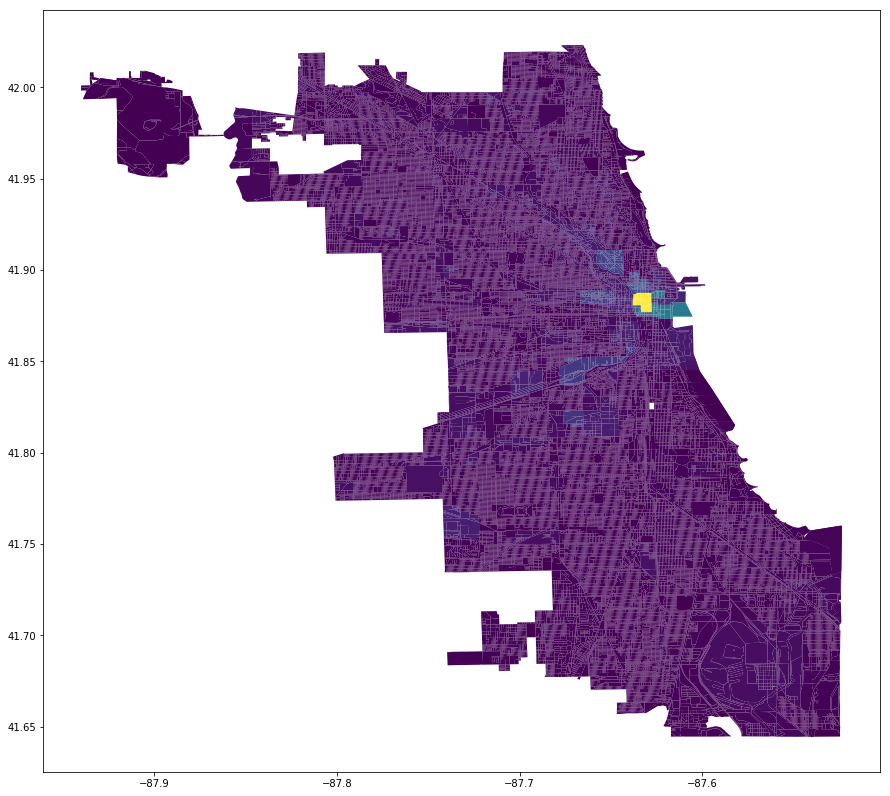

In [206]:
fig, ax = plt.subplots(figsize=(15, 15))
choro = blocks_ct_gdf.plot(ax=ax, column='business_count')
choro.figure.savefig('bus_ct_map.png')

In [213]:
augmented_df.application_type.unique()

array(['ISSUE', 'RENEW', 'C_SBA', 'C_LOC', 'C_CAPA', 'C_EXPA'],
      dtype=object)

In [222]:
new_blocks_ct_2015_2019 = augmented_df[(augmented_df['date_issued'].dt.year>=2015) & (augmented_df['application_type']=='ISSUE')].groupby('block_group')['account_number'].count().sort_values(ascending=False).reset_index().rename(columns={'account_number': 'business_count'})

In [223]:
recent_new_ct = pd.merge(new_blocks_ct_2015_2019, tracts_gdf, on='block_group')
recent_new_ct_gdf = gpd.GeoDataFrame(recent_new_ct, geometry='the_geom')

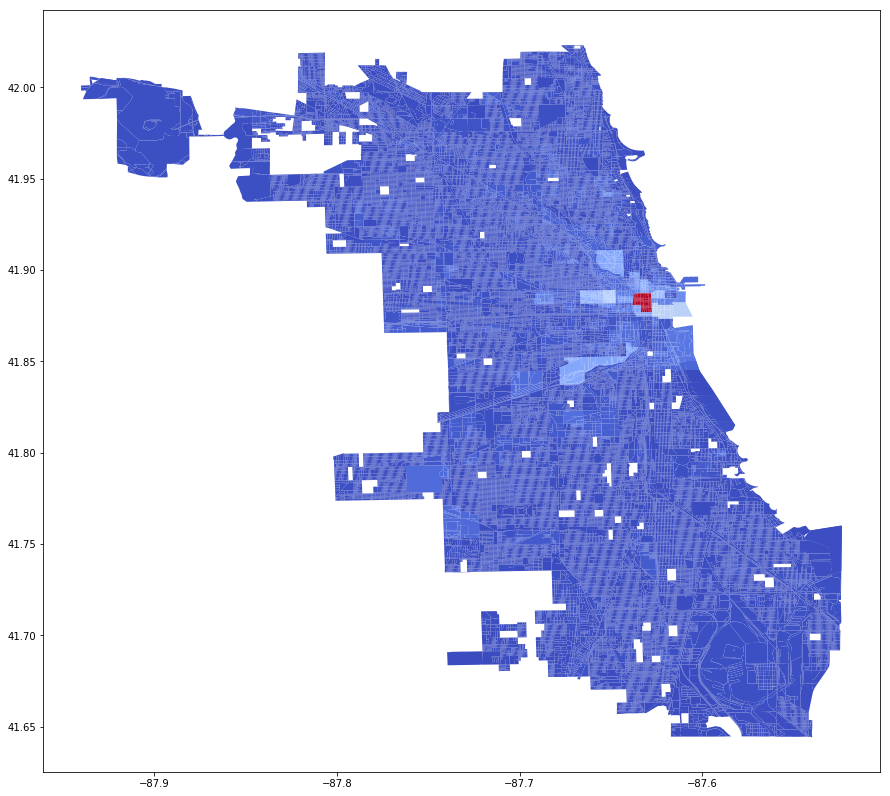

In [227]:
fig, ax = plt.subplots(figsize=(15, 15))
choro = recent_new_ct_gdf.plot(ax=ax, column='business_count', cmap='coolwarm')
choro.figure.savefig('new_bus_ct_map.png')

While similar as the overall, interesting that there are some tracts w/ no new businesses or 'issue' since 2015 --> diversity of location of new business really low

In [247]:
min_most_pop = blocks_ct_gdf.loc[blocks_ct_gdf['block_group'] != '170318391001']

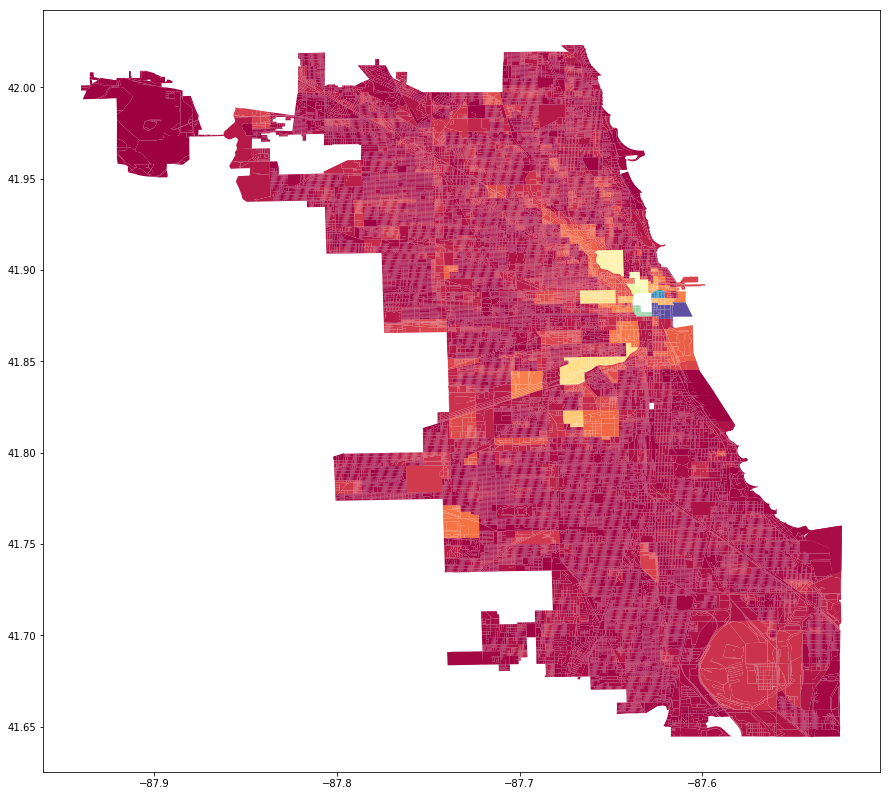

In [252]:
fig, ax = plt.subplots(figsize=(15, 15))
choro = min_most_pop.plot(ax=ax, column='business_count', cmap='Spectral')
choro.figure.savefig('overall_minus_one.png')

I cut out only the highest value in the one above and the one below because it was drowning out the others.

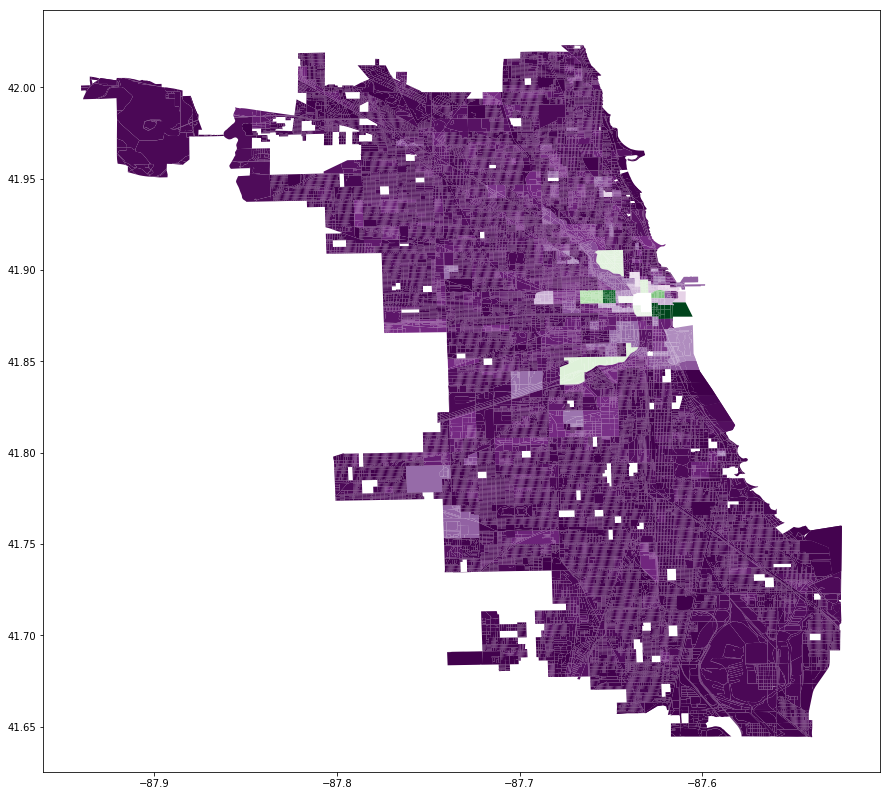

In [256]:
recent_new_ct_min_one = recent_new_ct_gdf.loc[recent_new_ct_gdf['block_group'] != '170318391001']
fig, ax = plt.subplots(figsize=(15, 15))
choro = recent_new_ct_min_one.plot(ax=ax, column='business_count', cmap='PRGn')
choro.figure.savefig('recent_minus_one.png')

Seems to be a bit more diversity from overall to 2015+ new businesses?